In [1]:
# Use black formatter
%load_ext lab_black

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
import matplotlib.pyplot as plt

RANDOM_SEED = 123

#### Carga y procesamiento de datos

In [2]:
FILE_PATH = "/tf/notebooks/CEIA-inteligencia_artificial/TP_final/dataset/possum.csv"

original_df = pd.read_csv(FILE_PATH, index_col=0)
df = original_df.copy()
df

,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
case,,,,,,,,,,,,,
1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,7,other,m,1.0,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0
101,7,other,m,1.0,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0
102,7,other,f,6.0,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0


Convertimos las columnas Pop y sex valores numericos 0 o 1 para poder trabajar con ellas. A continuación se muestra como se realizará el encoding.

|  Columna   |    valor   |  Encoding  | 
| :--------: | :--------: | :--------: |
| Pop        | Vic        | 1          |
| Pop        | other      | 0          |
| sex        | m          | 1          |
| sex        | f          | 0          |

In [3]:
pop_binary = pd.get_dummies(df.Pop)
pop_binary.pop("other")
pop_binary.columns = pop_binary.columns.str.lower()
sex_binary = pd.get_dummies(df.sex)
sex_binary.pop("f")

df = df.join([pop_binary, sex_binary])
df.pop("Pop")
df.pop("sex")
df

,site,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,vic,m
case,,,,,,,,,,,,,
1,1,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0,1,1
2,1,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0,1,0
3,1,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0,1,0
4,1,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0,1,0
5,1,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,7,1.0,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0,0,1
101,7,1.0,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0,0,1
102,7,6.0,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0,0,0


Chequeamos si hay observaciones con valor NaN.

In [4]:
df.isnull().sum()

site        0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
vic         0
m           0
dtype: int64

Como faltan algunos datos en la columna age, cuyos valores son números enteros, no seria buena idea completar con valores como por ejemplo la media, por eso se decide repetir el valor de la columna anterior. Esto se leva a cabo utilizando el parámetro *method="pad"* en la funcion *fillna*.

In [5]:
df.fillna(method="pad", inplace=True)
df.isnull().sum()

site        0
age         0
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    0
earconch    0
eye         0
chest       0
belly       0
vic         0
m           0
dtype: int64

#### a) Train test split
Es una buena práctica realizar primero la división del set de datos en conjuntos de train y test. De esta manera evitamos contaminar accidentalmente el conjunto de entrenamiento con información de test. Si esto sucediese posiblemente los resultados al evaluar el modelo en el set de test arrojarian valores superiores, pero al utilizarse el modelo en producción la performance sería menor.
Debido a que hay 104 muestras una division 80/20 es un buen ratio para los sets de train y test.

In [6]:
X = df.drop("m", axis=1).to_numpy()
y = df["m"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

Se normalizan los datos utilizando StandardScaler. Al tener features con valores de una misma magnitus se le hace más fácil al modelo encontrar una solución adecuada.

In [7]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

Se aplica un modelo de regresión logística, entrenado con el conjunto de train. Se decidió utilizar este modelo porque es un problema supervisado, y solo hay dos clases de salida.

In [8]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_scaled, y_train)

LogisticRegression()

Se calculan las métricas de Accuracy, Precision y Recall.

In [9]:
def print_metrics(y_true, y_pred, metrics=None):
    default_metrics = {
        "Accuracy": accuracy_score,
        "Precision": precision_score,
        "Recall": recall_score,
    }
    if metrics is None:
        metrics = default_metrics
    for name, metric in metrics.items():
        result = metric(y_true, y_pred)
        print(f"{name}: {result}")


print("Métricas de entrenamiento:")
print_metrics(y_train, logistic_regression.predict(X_train_scaled))

Métricas de entrenamiento:
Accuracy: 0.6987951807228916
Precision: 0.7368421052631579
Recall: 0.8076923076923077


In [10]:
X_test_scaled = scaler.transform(X_test)
y_pred = logistic_regression.predict(X_test_scaled)

print("Métricas de test:")
print_metrics(y_test, logistic_regression.predict(X_test_scaled))

Métricas de test:
Accuracy: 0.5714285714285714
Precision: 0.5
Recall: 0.6666666666666666


In [11]:
print("Valores reales de y", y_test)
print("Valores predichos", y_pred)

Valores reales de y [1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1]
Valores predichos [1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1]


b) En este caso tenemos un problema de regresión, por lo que se nos pide predecir una feature que toma valores continuos, totlngth. Utilizaremos un modelo de regresión lineal.

In [12]:
X = df.drop("totlngth", axis=1).to_numpy()
y = df["totlngth"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

Utilizamos PCA para reducir la dimensionalidad de los datos.

In [13]:
pca = PCA(n_components=1, random_state=RANDOM_SEED).fit(X_train)
X_train_pca = pca.transform(X_train)
print(
    "Se utiliza una componente de PCA, con una varianza de",
    pca.explained_variance_ratio_[0],
)

Se utiliza una componente de PCA, con una varianza de 0.4808074944030742


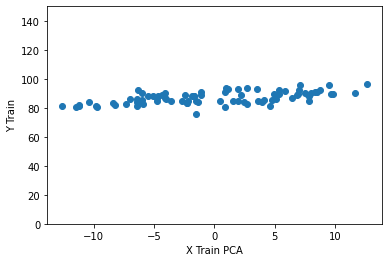

In [14]:
plt.scatter(X_train_pca, y_train)
plt.xlabel("X Train PCA")
plt.ylabel("Y Train")
plt.ylim((0, 150))
plt.show()

Los datos parecen tener una tendecia lineal, por lo tanto utilizará una recta de la forma *y = mx + b* para ajustar los datos.

In [15]:
scaler = StandardScaler().fit(X_train_pca)
X_train_pca_scaled = scaler.transform(X_train_pca)

In [16]:
linear_regression = LinearRegression()
linear_regression.fit(X_train_pca_scaled, y_train)

LinearRegression()

In [17]:
y_pred = linear_regression.predict(X_train_pca_scaled)

metrics = {"MSE": mean_squared_error, "R2": r2_score}

print("Métricas de entrenamiento:")
print_metrics(y_train, y_pred, metrics=metrics)

Métricas de entrenamiento:
MSE: 11.556105203900962
R2: 0.32638119129169696


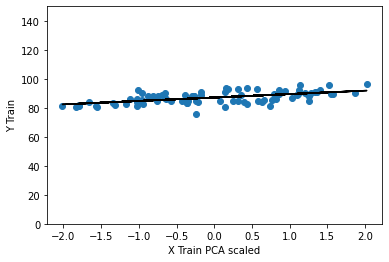

In [18]:
plt.scatter(X_train_pca_scaled, y_train)
plt.plot(X_train_pca_scaled, linear_regression.predict(X_train_pca_scaled), color="k")
plt.xlabel("X Train PCA scaled")
plt.ylabel("Y Train")
plt.ylim((0, 150))
plt.show()

In [19]:
X_test_pca = pca.transform(X_test)
X_test_pca_scaled = scaler.transform(X_test_pca)

y_pred = linear_regression.predict(X_test_pca_scaled)

print("Métricas de test:")
print_metrics(y_test, y_pred, metrics=metrics)

Métricas de test:
MSE: 19.344100535259876
R2: 0.170039564523072


In [20]:
print("Valores reales de y", y_test)
print("Valores predichos", y_pred)

Valores reales de y [91.5 88.  89.5 89.  84.  89.  91.5 90.5 89.  88.5 86.5 85.5 94.  87.5
 91.5 75.  82.  77.  81.  91.5 84. ]
Valores predichos [89.02055489 89.42092305 85.50546306 84.5969603  85.5976398  86.78975916
 89.67139675 89.67391887 91.14022823 85.14950199 82.9959582  89.00306877
 90.11441581 84.96392024 90.35499582 86.25006014 83.37771852 85.41210652
 88.06216577 90.08653595 90.07933079]


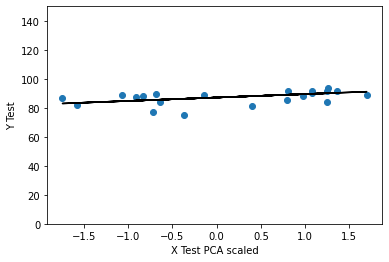

In [21]:
plt.scatter(X_test_pca_scaled, y_test)
plt.plot(X_test_pca_scaled, y_pred, color="k")
plt.xlabel("X Test PCA scaled")
plt.ylabel("Y Test")
plt.ylim((0, 150))
plt.show()